## training parameters

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
from functions import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
import pickle

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # 按照PCI_BUS_ID顺序从0开始排列GPU设备 
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3" #设置当前使用的GPU设备仅为0号设备  设备名称为'/gpu:0'import sys

# set path
data_path = "/home/jovyan/work/data/gyx/competition_face/train_face_img/"    # define RGB data path
temp = [0,1]
with open('filename.pkl','wb') as f:
    pickle.dump(temp, f, pickle.HIGHEST_PROTOCOL)
action_name_path = './filename.pkl'
save_model_path = "./Conv3D_ckpt/"  # save Pytorch models

# 3D CNN parameters
fc_hidden1, fc_hidden2 = 256, 256
dropout = 0.0        # dropout probability

# training parameters
k = 2           # number of target category
epochs = 15
batch_size = 30
learning_rate = 1e-4
log_interval = 10
img_x, img_y = 256, 342  # resize video 2d frame size

# Select which frame to begin & end in videos
begin_frame, end_frame, skip_frame = 1, 11, 1

## train

In [10]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    # set model as training mode
    model.train()

    losses = []
    scores = []
    N_count = 0   # counting total trained sample in one epoch
    for batch_idx, (X, y) in enumerate(train_loader):
        # distribute data to device
        X, y = X.to(device), y.to(device).view(-1, )

        N_count += X.size(0)

        optimizer.zero_grad()
        output = model(X)  # output size = (batch, number of classes)

        loss = F.cross_entropy(output, y)
        losses.append(loss.item())

        # to compute accuracy
        y_pred = torch.max(output, 1)[1]  # y_pred != output
        step_score = accuracy_score(y.cpu().data.squeeze().numpy(), y_pred.cpu().data.squeeze().numpy())
        scores.append(step_score)         # computed on CPU

        loss.backward()
        optimizer.step()

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accu: {:.2f}%'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item(), 100 * step_score))

    return losses, scores,optimizer

## validation

In [11]:
def validation(model, device, optimizer, test_loader):
    # set model as testing mode
    model.eval()

    test_loss = 0
    all_y = []
    all_y_pred = []
    with torch.no_grad():
        for X, y in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device).view(-1, )

            output = model(X)

            loss = F.cross_entropy(output, y, reduction='sum')
            test_loss += loss.item()                 # sum up batch loss
            y_pred = output.max(1, keepdim=True)[1]  # (y_pred != output) get the index of the max log-probability

            # collect all y and y_pred in all batches
            all_y.extend(y)
            all_y_pred.extend(y_pred)

    test_loss /= len(test_loader.dataset)

    # to compute accuracy
    all_y = torch.stack(all_y, dim=0)
    all_y_pred = torch.stack(all_y_pred, dim=0)
    test_score = accuracy_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy())

    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(len(all_y), test_loss, 100* test_score))

    return test_loss, test_score

## data files

In [12]:
# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

# Data loading parameters
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if use_cuda else {}


# load UCF101 actions names
with open(action_name_path, 'rb') as f:
    action_names = pickle.load(f)

# convert labels -> category
le = LabelEncoder()
le.fit(action_names)

# show how many classes there are
list(le.classes_)

# convert category -> 1-hot
action_category = le.transform(action_names).reshape(-1, 1)
enc = OneHotEncoder()
enc.fit(action_category)

# # example
# y = ['HorseRace', 'YoYo', 'WalkingWithDog']
# y_onehot = labels2onehot(enc, le, y)
# y2 = onehot2labels(le, y_onehot)

actions = []
fnames = os.listdir(data_path)
# print('fnames',fnames[0]) #'adylbeequz_10_FAKE.jpg'
all_names = []
all_labels = []
for f in fnames:
    name=f
    label=f.split('.jpg')[0].split('_')[2]   
    all_names.append(name)
    if label=='FAKE':
        label_NUM=0
    else:
        label_NUM=1
    all_labels.append(label_NUM)
    

# list all data files
all_X_list = all_names                  # all video file names
all_y_list = all_labels    # all video labels

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


## train, test split

In [13]:
# train, test split
train_list, test_list, train_label, test_label = train_test_split(all_X_list, all_y_list, test_size=0.25, random_state=42)

# image transformation
transform = transforms.Compose([transforms.Resize([img_x, img_y]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])])

selected_frames = np.arange(begin_frame, end_frame, skip_frame).tolist()

train_set, valid_set = Dataset_3DCNN(data_path, train_list, train_label, selected_frames, transform=transform), \
                       Dataset_3DCNN(data_path, test_list, test_label, selected_frames, transform=transform)
train_loader = data.DataLoader(train_set, **params)
valid_loader = data.DataLoader(valid_set, **params)

## Create model

In [14]:
# create model
cnn3d = CNN3D(t_dim=len(selected_frames), img_x=img_x, img_y=img_y,
              drop_p=dropout, fc_hidden1=fc_hidden1,  fc_hidden2=fc_hidden2, num_classes=k).to(device)

## GPUs

In [15]:
# Parallelize model to multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    cnn3d = nn.DataParallel(cnn3d)

Using 3 GPUs!


## training

In [16]:
optimizer = torch.optim.Adam(cnn3d.parameters(), lr=learning_rate)   # optimize all cnn parameters

# record training process
epoch_train_losses = []
epoch_train_scores = []
epoch_test_losses = []
epoch_test_scores = []

test_loss=1
# start training
for epoch in range(epochs):
    # train, test model
    train_losses, train_scores,optimizer = train(log_interval, cnn3d, device, train_loader, optimizer, epoch)
    epoch_test_loss, epoch_test_score = validation(cnn3d, device, optimizer, valid_loader)
    
    if epoch_test_loss < test_loss:
        test_loss = epoch_test_loss
        # save Pytorch models of best record
        if  not os.path.exists(save_model_path):#如果路径不存在
            os.makedirs(save_model_path)
        torch.save(cnn3d.state_dict(), os.path.join(save_model_path, '3dcnn_epoch{}.pth'.format(epoch + 1)))  # save spatial_encoder
        torch.save(optimizer.state_dict(), os.path.join(save_model_path, '3dcnn_optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
        print("Epoch {} model saved!".format(epoch + 1))
        
    # save results
    epoch_train_losses.append(train_losses)
    epoch_train_scores.append(train_scores)
    epoch_test_losses.append(epoch_test_loss)
    epoch_test_scores.append(epoch_test_score)

    # save all train test results
    A = np.array(epoch_train_losses)
    B = np.array(epoch_train_scores)
    C = np.array(epoch_test_losses)
    D = np.array(epoch_test_scores)
    np.save('./3DCNN_epoch_training_losses.npy', A)
    np.save('./3DCNN_epoch_training_scores.npy', B)
    np.save('./3DCNN_epoch_test_loss.npy', C)
    np.save('./3DCNN_epoch_test_score.npy', D)


Train Epoch: 1 [300/3000 (10%)]	Loss: 0.431978, Accu: 83.33%
Train Epoch: 1 [600/3000 (20%)]	Loss: 0.741856, Accu: 80.00%
Train Epoch: 1 [900/3000 (30%)]	Loss: 0.402275, Accu: 86.67%
Train Epoch: 1 [1200/3000 (40%)]	Loss: 0.428259, Accu: 80.00%
Train Epoch: 1 [1500/3000 (50%)]	Loss: 0.350688, Accu: 83.33%
Train Epoch: 1 [1800/3000 (60%)]	Loss: 0.547764, Accu: 76.67%
Train Epoch: 1 [2100/3000 (70%)]	Loss: 0.367751, Accu: 83.33%
Train Epoch: 1 [2400/3000 (80%)]	Loss: 0.544620, Accu: 73.33%
Train Epoch: 1 [2700/3000 (90%)]	Loss: 0.419297, Accu: 83.33%
Train Epoch: 1 [3000/3000 (100%)]	Loss: 0.432187, Accu: 80.00%

Test set (1000 samples): Average loss: 0.4729, Accuracy: 81.40%

Epoch 1 model saved!
Train Epoch: 2 [300/3000 (10%)]	Loss: 0.244133, Accu: 90.00%
Train Epoch: 2 [600/3000 (20%)]	Loss: 0.196502, Accu: 93.33%
Train Epoch: 2 [900/3000 (30%)]	Loss: 0.458368, Accu: 80.00%
Train Epoch: 2 [1200/3000 (40%)]	Loss: 0.204253, Accu: 93.33%
Train Epoch: 2 [1500/3000 (50%)]	Loss: 0.134300, A

Train Epoch: 12 [2700/3000 (90%)]	Loss: 0.007071, Accu: 100.00%
Train Epoch: 12 [3000/3000 (100%)]	Loss: 0.042628, Accu: 100.00%

Test set (1000 samples): Average loss: 0.4479, Accuracy: 88.60%

Train Epoch: 13 [300/3000 (10%)]	Loss: 0.011747, Accu: 100.00%
Train Epoch: 13 [600/3000 (20%)]	Loss: 0.059040, Accu: 96.67%
Train Epoch: 13 [900/3000 (30%)]	Loss: 0.072250, Accu: 96.67%
Train Epoch: 13 [1200/3000 (40%)]	Loss: 0.029856, Accu: 100.00%
Train Epoch: 13 [1500/3000 (50%)]	Loss: 0.006723, Accu: 100.00%
Train Epoch: 13 [1800/3000 (60%)]	Loss: 0.055720, Accu: 96.67%
Train Epoch: 13 [2100/3000 (70%)]	Loss: 0.018976, Accu: 100.00%
Train Epoch: 13 [2400/3000 (80%)]	Loss: 0.010006, Accu: 100.00%
Train Epoch: 13 [2700/3000 (90%)]	Loss: 0.083806, Accu: 96.67%
Train Epoch: 13 [3000/3000 (100%)]	Loss: 0.047907, Accu: 96.67%

Test set (1000 samples): Average loss: 0.6063, Accuracy: 87.50%

Train Epoch: 14 [300/3000 (10%)]	Loss: 0.019671, Accu: 100.00%
Train Epoch: 14 [600/3000 (20%)]	Loss: 0.12

## plot

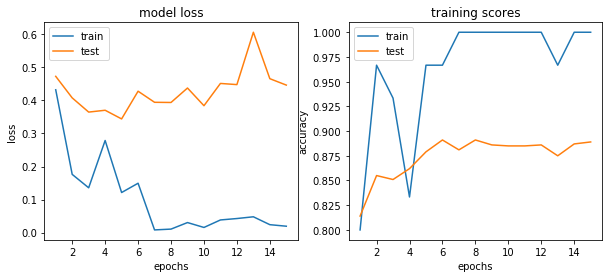

In [17]:
# plot
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(np.arange(1, epochs + 1), A[:, -1])  # train loss (on epoch end)
plt.plot(np.arange(1, epochs + 1), C)         #  test loss (on epoch end)
plt.title("model loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc="upper left")
# 2nd figure
plt.subplot(122)
plt.plot(np.arange(1, epochs + 1), B[:, -1])  # train accuracy (on epoch end)
plt.plot(np.arange(1, epochs + 1), D)         #  test accuracy (on epoch end)
# plt.plot(histories.losses_val)
plt.title("training scores")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc="upper left")
title = "./fig_face_3DCNN.png"
plt.savefig(title, dpi=600)
# plt.close(fig)
plt.show()


## predict

In [23]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
from functions import *
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
import pandas as pd
import pickle
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # 按照PCI_BUS_ID顺序从0开始排列GPU设备 
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3" #设置当前使用的GPU设备仅为0号设备  设备名称为'/gpu:0'import sys
# set path
data_path = "/home/jovyan/work/data/gyx/competition_face/test_face_img/"                # define UCF-101 RGB data path
action_name_path = "./filename.pkl"
save_model_path = "./Conv3D_ckpt/"

# 3D CNN parameters
fc_hidden1, fc_hidden2 = 256, 256
dropout = 0.0        # dropout probability

# training parameters
k = 2            # number of target category
batch_size = 30
img_x, img_y = 256, 342  # resize video 2d frame size

# Select which frame to begin & end in videos
begin_frame, end_frame, skip_frame = 1, 11, 1


with open(action_name_path, 'rb') as f:
    action_names = pickle.load(f)   # load UCF101 actions names

# convert labels -> category
le = LabelEncoder()
le.fit(action_names)

# show how many classes there are
list(le.classes_)

# convert category -> 1-hot
action_category = le.transform(action_names).reshape(-1, 1)
enc = OneHotEncoder()
enc.fit(action_category)

# # example
# y = ['HorseRace', 'YoYo', 'WalkingWithDog']
# y_onehot = labels2onehot(enc, le, y)
# y2 = onehot2labels(le, y_onehot)

actions = []
fnames = os.listdir(data_path)
# print('fnames',fnames[0]) #'adylbeequz_10_FAKE.jpg'
all_names = []
all_labels = []
for f in fnames:
    all_names.append(f)   
    

# list all data files
all_X_list = all_names                  # all video file names

# data loading parameters
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if use_cuda else {}

# image transformation
transform = transforms.Compose([transforms.Resize([img_x, img_y]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])])

selected_frames = np.arange(begin_frame, end_frame, skip_frame).tolist()



/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [24]:
class Dataset_3DCNN_test(data.Dataset):
    "Characterizes a dataset for PyTorch"
    def __init__(self, data_path, folders, frames, transform=None):
        "Initialization"
        self.data_path = data_path
        self.folders = folders
        self.transform = transform
        self.frames = frames

    def __len__(self):
        "Denotes the total number of samples"
        return len(self.folders)

    def read_images(self, path, selected_folder, use_transform):
        X = []
        for i in self.frames:
            image = Image.open(os.path.join(path, selected_folder)).convert('L')
#             image = Image.open(os.path.join(path, selected_folder, 'frame{:06d}.jpg'.format(i))).convert('L')

            if use_transform is not None:
                image = use_transform(image)

            X.append(image.squeeze_(0))
        X = torch.stack(X, dim=0)

        return X

    def __getitem__(self, index):
        "Generates one sample of data"
        # Select sample
        folder = self.folders[index]
        # Load data
        X = self.read_images(self.data_path, folder, self.transform).unsqueeze_(0)  # (input) spatial images    
        # print(X.shape)
        return X

In [25]:
# reset data loader
all_data_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 4, 'pin_memory': True} if use_cuda else {}
all_data_loader = data.DataLoader(Dataset_3DCNN_test(data_path, all_X_list, selected_frames, transform=transform), **all_data_params)


# reload  model
cnn3d = CNN3D(t_dim=len(selected_frames), img_x=img_x, img_y=img_y,
              drop_p=dropout, fc_hidden1=fc_hidden1,  fc_hidden2=fc_hidden2, num_classes=k).to(device)

# Parallelize model to multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    cnn3d = nn.DataParallel(cnn3d)

cnn3d.load_state_dict(torch.load(os.path.join(save_model_path, '3dcnn_epoch6.pth')))
print('CNN3D model reloaded!')

Using 3 GPUs!
CNN3D model reloaded!


In [26]:
# make all video predictions by reloaded model
print('Predicting all {} videos:'.format(len(all_data_loader.dataset)/10))
all_y_pred = Conv3d_final_prediction(cnn3d, device, all_data_loader)

  0%|          | 0/134 [00:00<?, ?it/s]

Predicting all 400.0 videos:


100%|██████████| 134/134 [00:30<00:00,  6.66it/s]


In [27]:
# write in pandas dataframe
df = pd.DataFrame(data={'filename': fnames, 'y_pred': cat2labels(le, all_y_pred)})
df.to_pickle("./face_videos_prediction.pkl")  # save pandas dataframe
# pd.read_pickle("./all_videos_prediction.pkl")
print('video prediction finished!')

video prediction finished!


## check

In [28]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 1000)

In [30]:
df = pd.read_pickle('./face_videos_prediction.pkl')
# df_new = pd.read_pickle('./face_videos_prediction_new.pkl')

In [32]:
df_new=df
for i in range(len(df_new['filename'])):
    df_new['filename'][i]=df_new['filename'][i].split('.jpg')[0].split('_')[0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
df_new_1=df_new.groupby('filename').mean()

In [34]:
len(df_new_1)

400

In [35]:
df_new_1

,y_pred
filename,
aassnaulhq,0.0
aayfryxljh,0.1
acazlolrpz,0.0
adohdulfwb,0.0
ahjnxtiamx,0.0
ajiyrjfyzp,0.0
aktnlyqpah,0.0
alrtntfxtd,0.0
aomqqjipcp,0.0
